

# Time Series Analysis & Classification Project
- Title: **Forecasting Airplane Crashes: A Time Series Analysis**
- Author: **OULAD ALI Marouane Abdeldjalil**
- Group: **02**

## Abstract
In this project, we conduct a time series analysis of airplane crashes data to forecast future occurrences. The dataset comprises historical data on the number of airplane crashes per year, spanning multiple years (From 1915 to 2009). Our goal is to develop a forecasting model that can accurately predict the number of airplane crashes in upcoming years. Through this analysis, we aim to contribute insights into aviation safety and risk management.

## Introduction
The aviation industry plays a crucial role in global transportation, with millions of flights occurring annually. However, airplane crashes remain a significant concern due to their potential impact on human lives and safety. Understanding the patterns and trends in airplane crashes can provide valuable insights for improving aviation safety measures.

In this project, we focus on analyzing historical data related to airplane crashes. The dataset includes information about the number of airplane crashes per year over a specific time period. By applying time series analysis techniques, we aim to uncover patterns, trends, and seasonality in the data. Additionally, we seek to develop a forecasting model that can predict the future occurrences of airplane crashes based on historical trends.

Through this analysis, we strive to enhance our understanding of the factors influencing airplane crashes and contribute to the development of predictive models for aviation safety management.



We'll start by installing the needed packages

In [1]:
install.packages('TSA')
install.packages('forecast')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’, ‘leaps’, ‘locfit’, ‘tseries’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’




And now it's time to load the dataset from csv file

In [11]:
library(dplyr)

# Load the dataset from CSV file
airplane_crashes <- read.csv("airplane_crashes_dataset.csv")

# Check the structure of the dataset
str(airplane_crashes)


'data.frame':	5263 obs. of  13 variables:
 $ Date        : chr  "03/05/1915" "09/03/1915" "07/28/1916" "09/24/1916" ...
 $ Time        : chr  "01:00" "15:20" "" "01:00" ...
 $ Location    : chr  "Tienen, Belgium" "Off Cuxhaven, Germany" "Near Jambol, Bulgeria" "Billericay, England" ...
 $ Operator    : chr  "Military - German Navy" "Military - German Navy" "Military - German Army" "Military - German Navy" ...
 $ Flight..    : chr  "" "" "" "" ...
 $ Route       : chr  "" "" "" "" ...
 $ Type        : chr  "Zeppelin L-8 (airship)" "Zeppelin L-10 (airship)" "Schutte-Lanz S-L-10 (airship)" "Zeppelin L-32 (airship)" ...
 $ Registration: chr  "" "" "" "" ...
 $ cn.In       : chr  "" "" "" "" ...
 $ Aboard      : int  41 19 20 22 19 28 20 20 23 21 ...
 $ Fatalities  : int  21 19 20 22 19 27 20 20 23 21 ...
 $ Ground      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Summary     : chr  "Crashed into trees while attempting to land after being shot down by British and French aircraft." "Exploded and burned

**Dataset Description: Airplane Crashes Data**

The dataset contains information about airplane crashes, including details such as date, time, location, operator, flight, route, type of aircraft, registration number, aircraft construction number (cn_in), number of people aboard, number of fatalities, number of ground casualties, and a summary of the crash.

- **Date:** The date when the airplane crash occurred.
- **Time:** The time of the crash.
- **Location:** The geographical location (city, country) where the crash occurred.
- **Operator:** The airline or operator of the aircraft involved in the crash.
- **Flight:** Flight number or identifier.
- **Route:** The planned route of the flight.
- **Type:** The type or model of the aircraft involved.
- **Registration:** The registration number of the aircraft.
- **Cn_in:** The aircraft construction number.
- **Aboard:** The total number of people aboard the aircraft.
- **Fatalities:** The number of fatalities resulting from the crash.
- **Ground:** The number of ground casualties (if any).
- **Summary:** A brief summary or description of the crash.

**Source of the data:** https://data.world/data-society/airplane-crashes

Our focus will be on the number of crashes per each year, therefore we'll group the crashes per year and calculate the number for crashes for each year

In [12]:
# Convert Date column to Date format
airplane_crashes$Date <- as.Date(airplane_crashes$Date, format = "%m/%d/%Y")

# Extract year from Date and group crashes per year
crashes_per_year <- airplane_crashes %>%
  mutate(year = as.integer(format(Date, "%Y"))) %>%
  group_by(year) %>%
  summarize(num_of_crashes = n())

# Print the resulting dataset
print(crashes_per_year)

# A tibble: 95 × 2
    year num_of_crashes
   <int>          <int>
 1  1915              2
 2  1916              5
 3  1917              6
 4  1918              4
 5  1919              6
 6  1920             17
 7  1921             13
 8  1922             11
 9  1923             12
10  1924              7
# ℹ 85 more rows



Now that our time series data related to airplane crashes is ready, let's plot it to gain an initial insight into its patterns and characteristics.

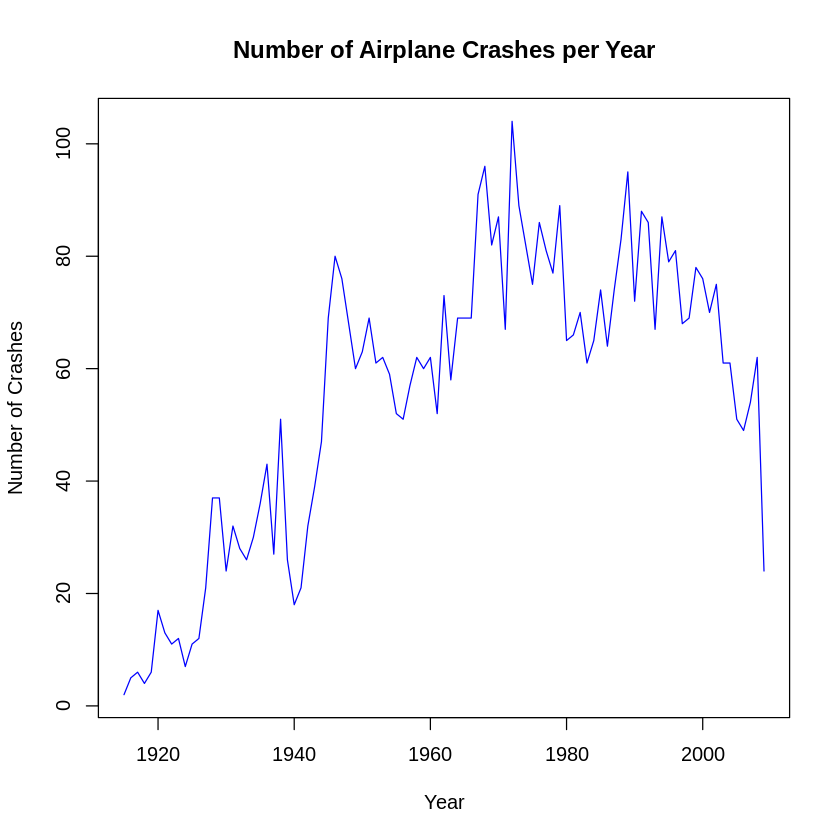

In [13]:
# Plotting the number of crashes per year as a line plot
plot(crashes_per_year$year, crashes_per_year$num_of_crashes,
     type = "l",
     col = "blue",
     xlab = "Year", ylab = "Number of Crashes",
     main = "Number of Airplane Crashes per Year")


After visualizing the data through plotting, it becomes apparent that there is a consistent rise in the values over time, indicating a clear upward trend in the dataset. This upward trend signifies that the data is not stationary, as it shows a systematic change in its mean and variance over the observed period. And clearly, there's no seasonality or periodicity in our data.

Despite the evident non-stationarity observed in the graph, let's conduct an Augmented Dickey-Fuller (ADF) test to formally confirm the non-stationarity of the time series data related to airplane crashes.

In [14]:
# Load the necessary library for ADF test
library(tseries)

# Perform Augmented Dickey-Fuller (ADF) test on the data
adf_result <- adf.test(crashes_per_year$num_of_crashes)

# Print the ADF test results
print(adf_result)



	Augmented Dickey-Fuller Test

data:  crashes_per_year$num_of_crashes
Dickey-Fuller = -0.80869, Lag order = 4, p-value = 0.9578
alternative hypothesis: stationary



> The Augmented Dickey-Fuller (ADF) test yields a test statistic of -0.80869 and a p-value of 0.9578. Since the p-value is high (> 0.05), we fail to reject the null hypothesis of non-stationarity. Thus, the data is likely non-stationary according to the ADF test.

## Model specification

We observed from the plot that the variance of the time series data related to airplane crashes isn't stable, indicating the presence of heteroscedasticity. To address this issue, we will perform a variance-stabilizing transformation using the Box-Cox method. The optimal lambda parameter for the Box-Cox transformation is determined by maximizing the log-likelihood function, ensuring the best fit to the data.

We will use the `BoxCox.Ar()` function, which is designed to automatically find the optimal lambda value for the Box-Cox transformation. This optimal lambda corresponds to the value that results in the highest log-likelihood, indicating the most suitable transformation for stabilizing the variance of the data.

Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”
Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim

[1] 0.6


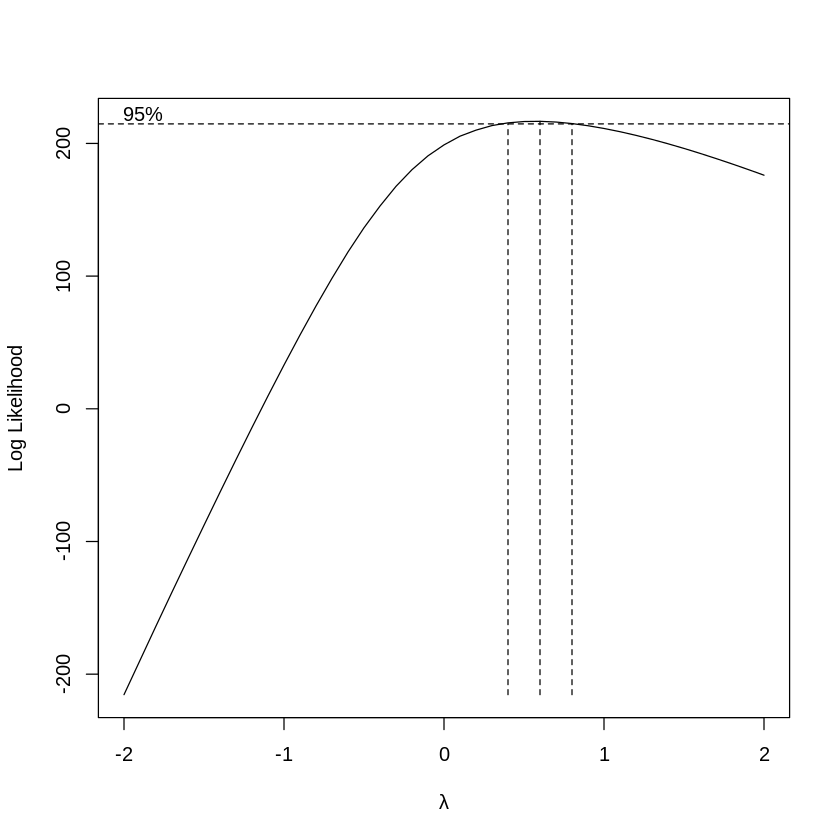

In [15]:
# Load the necessary libraries
library(MASS)
library(TSA)

# Perform Box-Cox transformation using BoxCox.ar()
boxcox_result <- BoxCox.ar(crashes_per_year$num_of_crashes)

# Extract lambda values and log-likelihoods
lambda_values <- boxcox_result$lambda
log_likelihoods <- boxcox_result$loglik

# Find the index of the lambda value with maximum log-likelihood
max_log_likelihood_index <- which.max(log_likelihoods)

# Extract the optimal lambda value
optimal_lambda <- lambda_values[max_log_likelihood_index]

# Print the optimal lambda value
print(optimal_lambda)


The optimal lambda value obtained for the Box-Cox transformation using the `BoxCox.Ar()` function is 0.6. In the context of Box-Cox transformation, a lambda value of 0.6 almost corresponds to taking the square root of the data. Therefore, we will perform the Box-Cox transformation using lambda = 0.6 to stabilize the variance of the time series data related to airplane crashes.

Registered S3 methods overwritten by 'forecast':
  method       from
  fitted.Arima TSA 
  plot.Arima   TSA 



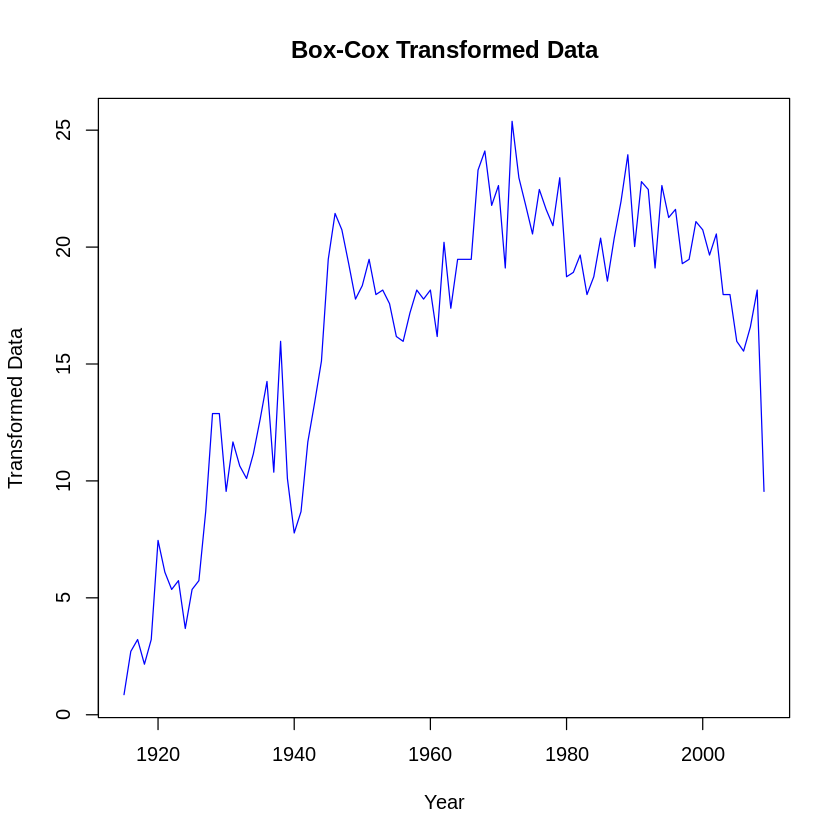

In [16]:
library(forecast)

transformed_data <- BoxCox(crashes_per_year$num_of_crashes, lambda = optimal_lambda)

# Plot the transformed data
plot(crashes_per_year$year, transformed_data,
     type = "l",
     col = "blue",
     xlab = "Year", ylab = "Transformed Data",
     main = "Box-Cox Transformed Data")

The next step in our analysis is to remove the trend by applying the first difference to the time series data. Differencing is a common technique used in time series analysis to remove trends or seasonality from the data, making it more stationary

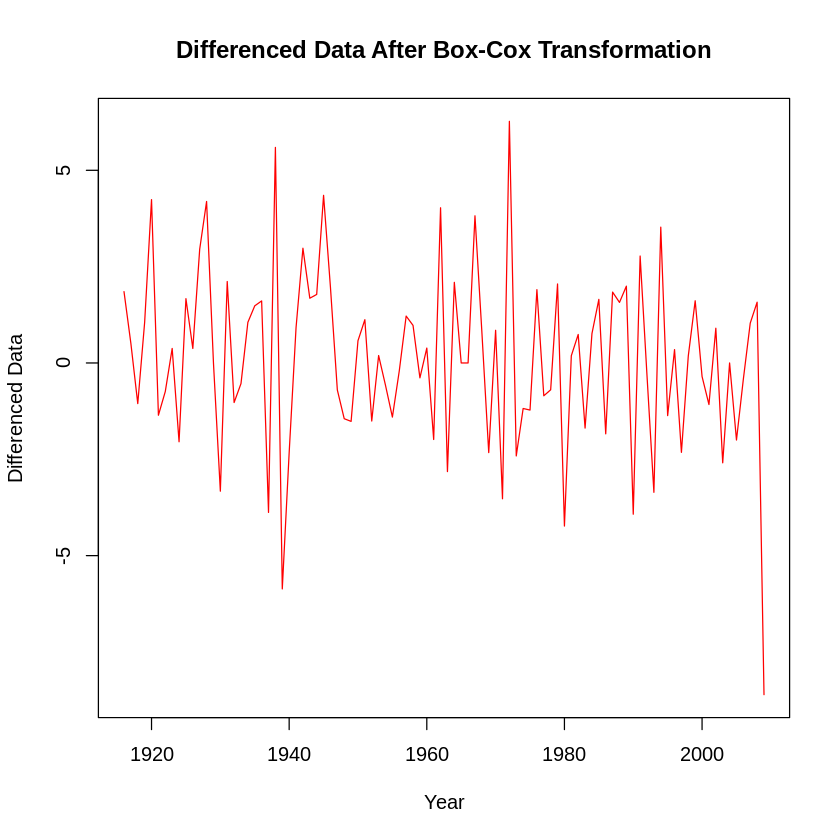

In [17]:
# Perform differencing on the transformed data
differenced_data <- diff(transformed_data)

# Plot the differenced data
plot(crashes_per_year$year[-1], differenced_data,
     type = "l",
     col = "red",
     xlab = "Year", ylab = "Differenced Data",
     main = "Differenced Data After Box-Cox Transformation")

Now that we have applied the first difference to remove the trend from our time series data, the next step is to check if the differenced data is stationary. We will use the Augmented Dickey-Fuller (ADF) test again for this purpose.



In [18]:
# Load the necessary library for ADF test
library(tseries)

# Perform Augmented Dickey-Fuller (ADF) test on differenced data
adf_result <- adf.test(differenced_data)

# Print the ADF test results
print(adf_result)


Warning message in adf.test(differenced_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  differenced_data
Dickey-Fuller = -5.4917, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



The Augmented Dickey-Fuller (ADF) test on the differenced data yields a test statistic of -5.4917 and a p-value of 0.01. With a p-value below the significance level of 0.05, we reject the null hypothesis of non-stationarity. Therefore, the differenced data is considered stationary, indicating that the removal of the trend has successfully transformed the data into a stationary series, suitable for time series modeling and forecasting.

Now that we have confirmed the stationarity of the first difference (d = 1), we will proceed to select the appropriate values of p and q for our ARIMA model. These parameters, along with d, determine the order of autoregressive (AR) terms (p), differencing (d), and moving average (MA) terms (q) in the ARIMA model used to model the dataset.

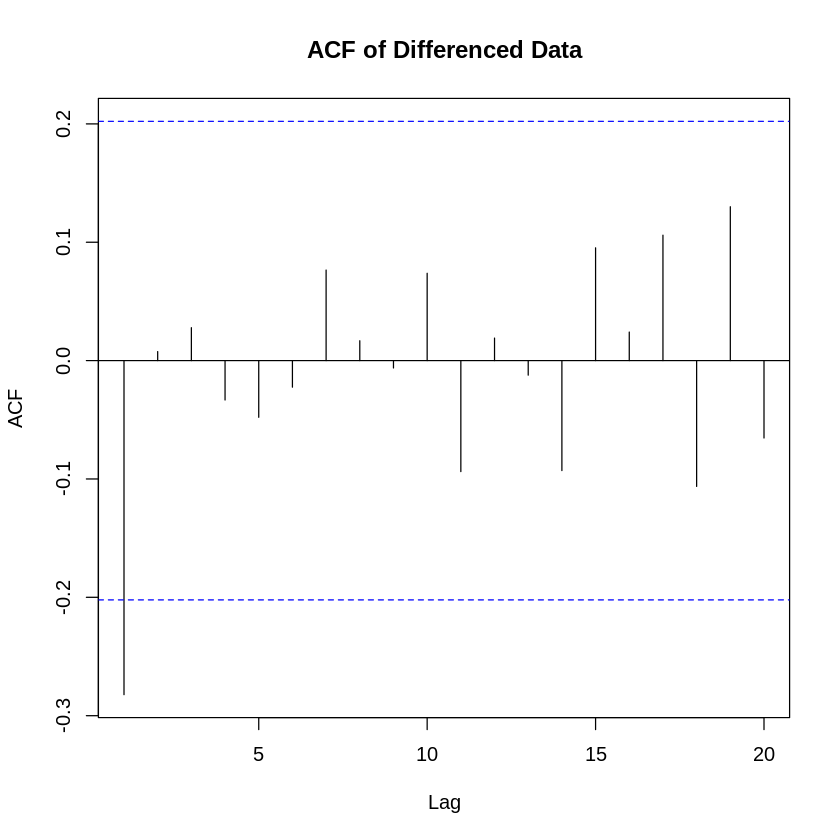

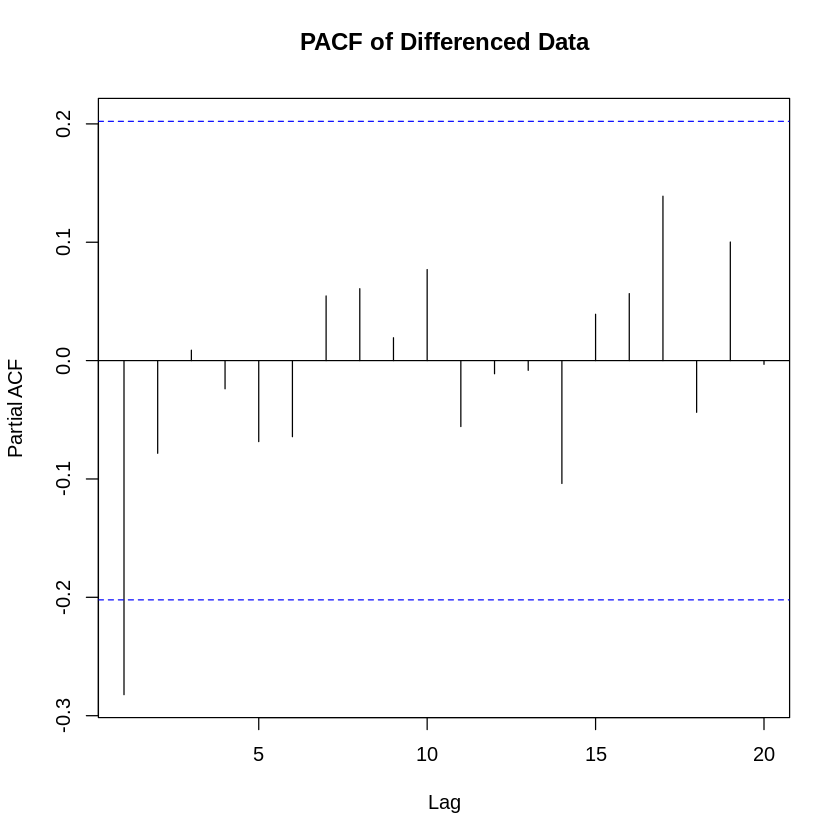

In [19]:
# Plot ACF and PACF of differenced data
acf_differenced <- acf(differenced_data, lag.max = 20, plot = TRUE, main = "ACF of Differenced Data")
pacf_differenced <- pacf(differenced_data, lag.max = 20, plot = TRUE, main = "PACF of Differenced Data")


The ACF and PACF of the differenced data show significant correlations only at lag 1, indicating a potential ARIMA(1,1,1) model. This observation is supported by the hypothesis that an autoregressive term of order 1 (AR(1)) and a moving average term of order 1 (MA(1)) may be suitable. We will further validate this hypothesis using AIC and BIC criteria for model selection

Therfore, we will evaluate several candidate ARIMA models, varying their autoregressive (p), differencing (d), and moving average (q) orders. The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) will guide us in selecting the best-performing model with optimal balance between complexity and fit.

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“9  linear dependencies found”


Reordering variables and trying again:


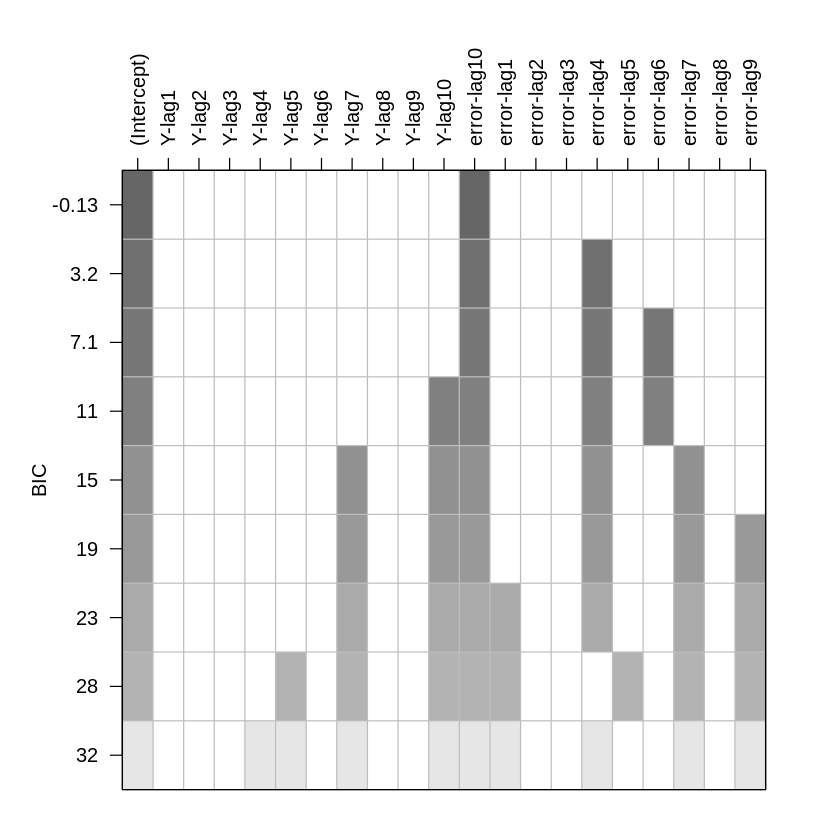

In [20]:
# Load the TSA package
library(TSA)

# Plot the ARIMA model selection results using armasubsets
plot(armasubsets(differenced_data, nar = 10, nma = 10))


In [21]:
library(forecast)

# Use auto.arima() to automatically select the best ARIMA model
auto_model <- auto.arima(crashes_per_year$num_of_crashes)

# Print the summary of the auto-selected model
print(summary(auto_model))


Series: crashes_per_year$num_of_crashes 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.4023
s.e.   0.0954

sigma^2 = 116.7:  log likelihood = -356.66
AIC=717.33   AICc=717.46   BIC=722.41

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE     MASE
Training set 0.6256068 10.68808 8.167618 -0.4010511 19.05293 0.936288
                   ACF1
Training set -0.0288301


In [22]:
# Fit ARIMA models with different orders
arima_110 <- arima(differenced_data, order = c(1, 0, 0))
arima_011 <- arima(differenced_data, order = c(0, 0, 1))
arima_111 <- arima(differenced_data, order = c(1, 0, 1))
arima_211 <- arima(differenced_data, order = c(2, 0, 1))
arima_212 <- arima(differenced_data, order = c(2, 0, 2))

# Compare AIC and BIC of the fitted models
models <- list(arima_110, arima_011, arima_111, arima_211, arima_212)
aic_values <- sapply(models, AIC)
bic_values <- sapply(models, BIC)

# Identify the model with the lowest AIC and BIC
best_model_aic <- models[[which.min(aic_values)]]
best_model_bic <- models[[which.min(bic_values)]]

# Print information about the best models
print("Best model based on AIC:")
print(summary(best_model_aic))
print("Best model based on BIC:")
print(summary(best_model_bic))


[1] "Best model based on AIC:"

Call:
arima(x = differenced_data, order = c(0, 0, 1))

Coefficients:
          ma1  intercept
      -0.3522     0.1162
s.e.   0.1034     0.1513

sigma^2 estimated as 5.06:  log likelihood = -209.65,  aic = 423.31

Training set error measures:


Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”


              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN
[1] "Best model based on BIC:"

Call:
arima(x = differenced_data, order = c(0, 0, 1))

Coefficients:
          ma1  intercept
      -0.3522     0.1162
s.e.   0.1034     0.1513

sigma^2 estimated as 5.06:  log likelihood = -209.65,  aic = 423.31

Training set error measures:


Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”


              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


> Based on the results obtained from `auto.arima()`, as well as the AIC and BIC criteria, it is clear that the optimal model is the ARIMA(0,1,1) model.

Now, we will conduct a thorough analysis of the residuals for our model to see how good it is

## Fitting and Diagnostics

We begin by fitting our ARIMA(0,1,1) to our data.

In [23]:
arima_011 <- arima(crashes_per_year$num_of_crashes, order = c(0, 1, 1))

### Residual Analysis

After fitting the model, we calculate the standardized residuals for our ARIMA(0,1,1). These standardized residuals allow us to assess the goodness of fit and the adequacy of the model

In [24]:
# Get standardized residuals for ARIMA(0,1,1) model
residuals_011 <- residuals(arima_011) / sqrt(var(residuals(arima_011)))

Now we plot the standardized residuals for both ARIMA(2,1,2) and ARIMA(1,1,1). These plots provide a visual representation of the residuals' behavior and allow us to assess the goodness of fit and the adequacy of the models

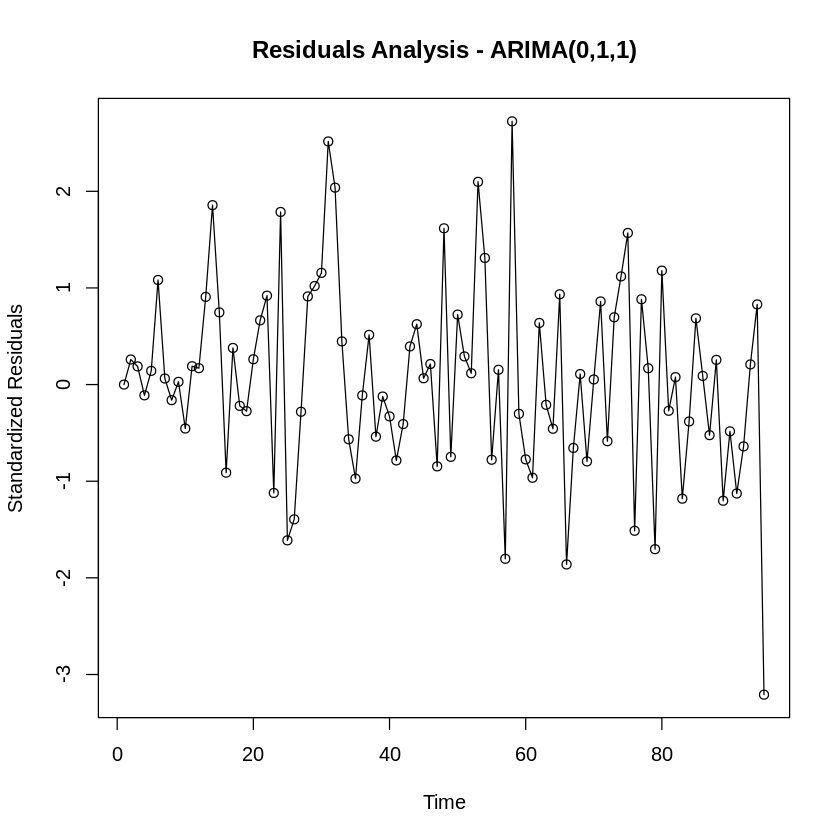

In [25]:
# Plot standardized residuals for ARIMA(0,1,1) model
plot(residuals_011, type = "o", ylab = "Standardized Residuals", main = "Residuals Analysis - ARIMA(0,1,1)")


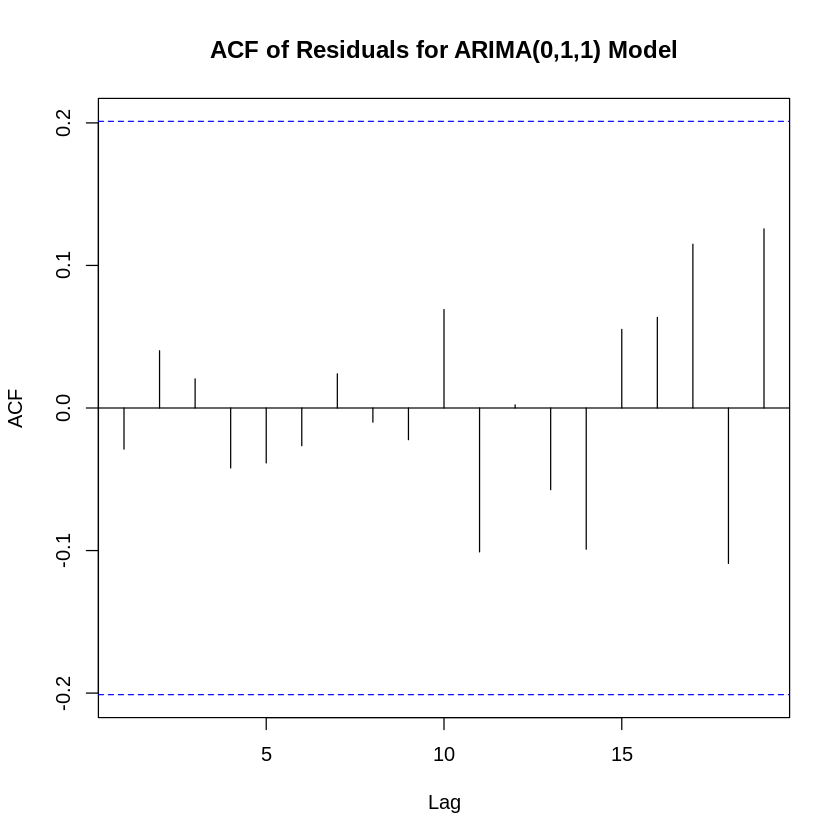

In [26]:
acf(residuals_011, main = "ACF of Residuals for ARIMA(0,1,1) Model")

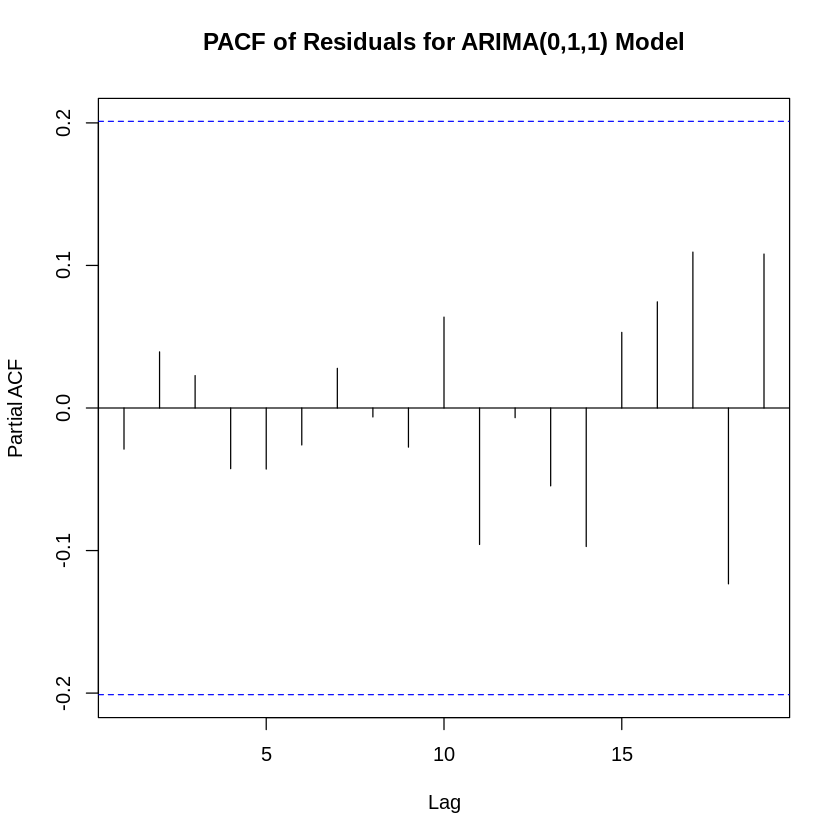

In [27]:
pacf(residuals_011, main = "PACF of Residuals for ARIMA(0,1,1) Model")

> Upon examining the ACF and PACF plots for both the standardized residuals of our ARIMA(0,1,1) model, we observed that all lags fall within the confidence interval. This indicates that there are no significant autocorrelations or partial autocorrelations in the residuals.

In [28]:
runs(residuals_011)

$pvalue
[1] 0.733

$observed.runs
[1] 50

$expected.runs
[1] 47.86316

$n1
[1] 42

$n2
[1] 53

$k
[1] 0

> The runs test, with p-values of 0.733, confirms the independence of the standardized residuals in our model. This test assesses whether the observed arrangement of runs differs significantly from what would be expected under randomness. The high p-values indicate that the runs are consistent with randomness, supporting the assumption of independence in the residuals.

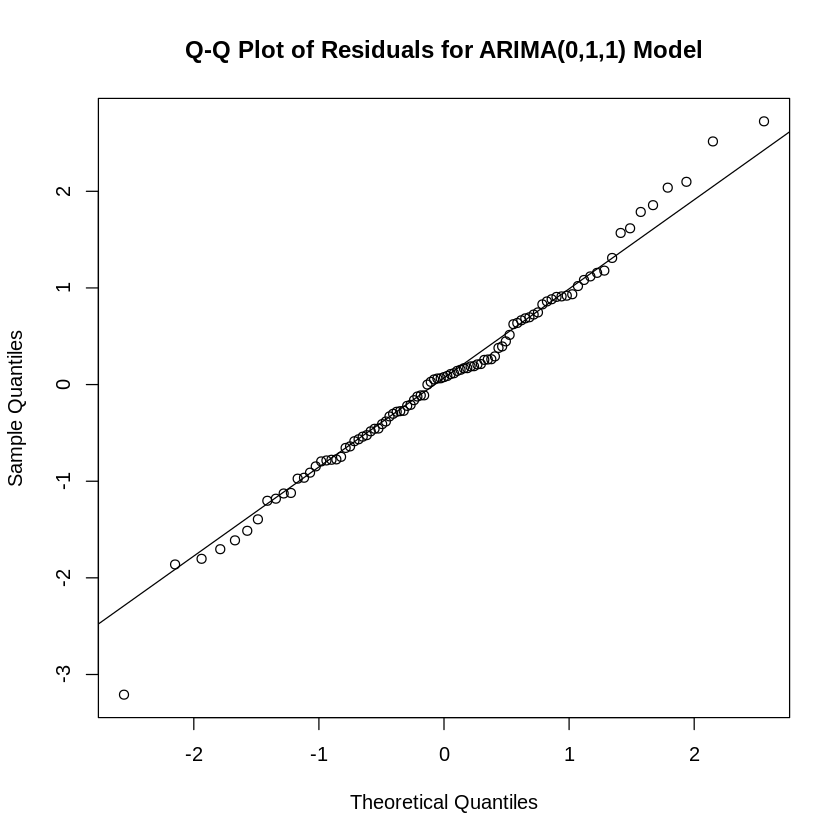

In [29]:
qqnorm(residuals_011, main = "Q-Q Plot of Residuals for ARIMA(0,1,1) Model")
qqline(residuals_011)


In [30]:
shapiro.test(residuals_011)


	Shapiro-Wilk normality test

data:  residuals_011
W = 0.98841, p-value = 0.5758


> The Shapiro-Wilk normality test was conducted on the standardized residuals of ARIMA(0,1,1), the W statistic was 0.98841 with a p-value of 0.5758, suggesting that the residuals are reasonably normally distributed.

### Residual Analysis Summary

The residuals analysis for our model ARIMA(0,1,1) models showed that the residuals are normally distributed and exhibit independence, which are important assumptions for forecasting. The Shapiro-Wilk normality test yielded p-value of 0.5758 , indicating that the residuals can be considered normally distributed. Additionally, the runs test for independence resulted in p-value of 0.733, suggesting that the residuals exhibit no significant autocorrelation or pattern in their sequence of runs. These findings support the suitability of our model for forecasting future observations.

## Forecasting

In this step, we'll use the chosen ARIMA model, to forecast future observations. The forecasting process involves utilizing the trained model to generate predictions for the time period beyond our training data. We'll evaluate the accuracy of our forecasts by comparing them with the actual values from the withheld test data. This comparison will allow us to assess the predictive performance of the selected model and draw conclusions about its suitability for forecasting the time series data related to airplane crashes. Additionally, we'll discuss any adjustments or considerations made during the forecasting process to improve the reliability of our predictions.

Let's start by splitting the data into training and test sets. We'll use the training set to fit the models and the test set to evaluate their performance

In [40]:
# Split the data into training and test sets
train_data <- crashes_per_year[1:90, ]
test_data <- crashes_per_year[91:95, ]

Now, let's fit the ARIMA model using the training data and forecast future observations

In [42]:
library(forecast)

# Choose and fit the forecasting model (e.g., ARIMA)
model <- Arima(train_data$num_of_crashes, order = c(0,1,1))

# Forecast future observations
forecast_values <- forecast(model, h = length(test_data$num_of_crashes))$mean

# Calculate MSE or RMSE
mse <- mean((test_data$num_of_crashes - forecast_values)^2)
rmse <- sqrt(mse)
cat("Mean Squared Error:", mse, "\n")
cat("Root Mean Squared Error:", rmse, "\n")


Mean Squared Error: 389.0119 
Root Mean Squared Error: 19.72338 


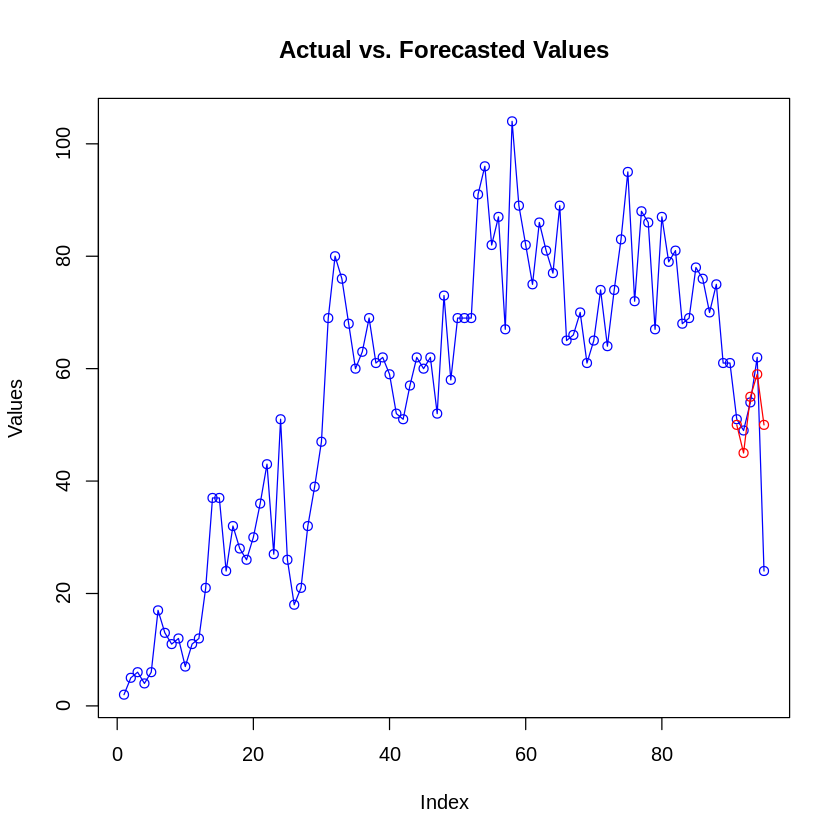

In [47]:
# Plot the actual and forecasted data
plot(crashes_per_year$num_of_crashes, type = "o", col = "blue", xlab = "Index", ylab = "Values", main = "Actual vs. Forecasted Values")
lines(forecast_values, type = "o", col = "red")


> Our model gave reasonably acceptable forecasted values which means our model **ARIMA(0,1,1)** performed well on this data.

## Discussion

**Insights on the data**

The increase in airplane crashes after 1920 can be attributed to the rapid expansion of airplane construction during that period. However, after 1990, the number of crashes began to decline noticeably. This decline can be linked to the implementation of various safety measures by airplane manufacturers, highlighting the industry's commitment to improving safety standards over time.

**Our Goal**

We wanted to build a model to predict how many airplane crashes might happen each year. We looked at data from many years of crashes.

**What We Did**

1. **Analyzed the Data:** We investigated patterns in the data, like if crashes were increasing or decreasing over time, and if there were any seasonal trends.
2. **Picked the Best Model:** We tried out different models to see which one could predict crashes the most accurately. We used tests and comparisons to pick the best model.
3. **Tested the Model:** We split the data into two parts. We trained the model on one part and then tested it on the other part to see how well it could predict crashes it hadn't seen before.

**Challenges and Results**

It wasn't always easy, especially because the data wasn't stationary. But in the end, we found a model that could predict crashes pretty well. This can help the aviation industry improve safety by understanding crash patterns and taking steps to prevent them.

**Why This Matters**

Using data and models to predict crashes can help keep airplanes safe. This project shows that analyzing data and building models can be a powerful tool for improving aviation safety.
